# Nehladká Newtonova metoda

Jedním ze základních předpokladů Newtonovy metody je, že funkce $f(x)$ je spojitá a hladká a jsme schopni vyjádřit její derivaci $f(x)$ na celém intervalu. Což je pro mnoho aplikací poměrně silný předpoklad.

Newtonova metoda a její konvergence zůstává v platnost i pro nehladké funkce, jen je potřeba věnovat dostatečnou pozornost volbě tečné matice. Pro tzv. "semismooth" funkce metoda zůstává konvergentní za předpokladu, že je pro výpočet dalšího kroku vzata nějaká funkce, která je subgradientem (subderivací) funkce, u které hledáme kořen. Jako primitivní příklad lze představit funkci

$$
f(x)=\max\{0, x\}.
$$

Tato funkce má klasickou derivaci definovanou všude až na bod $x=0$. V tomto bodě existují jednostranné derivace. Levostranná derivace je rovna 0, zatímco pravostranná je rovna 1. Subderivace v tomto bodě je jednoduše definována jako množina $\langle 0,1\rangle$. 

Jedním velmi podobným typickým příkladem pro využití nehladké Newtonovy metody je hledání optimálního $x$ pro které platí

$$
h(x)=\min\{f(x), g(x)\}=0.
$$

Na tokový probém tedy využijeme klasickou Newtonovu metodu a pro následující odhad, kde pro konkrétní aproximaci hledaného bodu $x_i$ spočteme její zpřesnění $x_{i+1}$ rovnicí

$$
x_{i+1} = x_{i} - \frac{h(x)}{h'(x)},
%h'(x)\Delta x = -h(x),
$$

kde 

$$
h'(x)=\begin{cases} f'(x),\quad f(x) < g(x) \\ g'(x),\quad f(x)>g(x)\end{cases}.
$$

Navíc v bodě $\bar{x}$, kde $f(\bar{x})=g(\bar{x})$ můžeme derivaci dodefinovat libovolnou hodnotou, musí však být z intervalu $\langle f'(\bar{x}), g'(\bar{x})\rangle$.

## Příklad použití
Jeden z možných využití představené nehladké funkce je průhyb nosníku pod kterým je nějaká nedeformovatelá překážka zadaná analytickou funkcí.

Průhyb nosníku je popsán rovnicí 4. řádu

$$
\left(EIw''(x)\right)''= f(x),
$$

kde $EI$ je tuhost průřezu, $f(x)$ je vnější zatížení a $w(x)$ je hledaná funkce průhybu. Navíc je zde daná překážka $\varphi(x)$, pod kterou se nesmí nosník prohnout. Takový problém lze popsat následující rovnicí

$$
\min\left\{\left(EIw''(x)\right)''-f(x); w(x)-\varphi(x)\right\} = 0,
$$

která říká, že v místech, kde nosník nedosáhne omezující plochy musí být splněna diferenciání rovnice, zatímco v místech, kde $w(x)=\varphi(x)$ nemusí být rovnice v platnosti.

### Implementace

Způsob diskretizace parciální diferenciální rovnice není tématem této části, proto je zde uvedena tato problematika velice stručně. Tuhost nosníku uvažujeme konstantní $EI=1$. Diferenciální rovnici vyšetřujeme v sadě diskrétních bodů $x_0, x_1, \ldots, x_n$ a čtvrtou derivaci aproximujeme pomocí centrálních diferencí. Tím pádem se naše diferenciální rovnice přemění na soustavu algebraických rovnic $\mathbf{K}\mathbf{w}=\mathbf{F}$, kde 

$$
\mathbf{K}=\frac{1}{h^4}
\begin{pmatrix}
6 & -4 & 1 & \cdots & 0 \\
-4 & 6 & -4 \\
\vdots & & & \ddots & -4 \\
0 & \cdots & & -4 & 6
\end{pmatrix}
$$

je matice tuhosti, $\mathbf{w}$ je vektor neznámých průhybů v místech $x_i$ a $\mathbf{F}$ je vektor zatížení. Navíc $h$ je prostorový krok, tedy $h=x_{i+1}-x_i$. I druhou funkci přepíšeme do diskrétní varianty jako $\mathbf{w}-{\boldsymbol \varphi}$.

In [11]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt


def seminewton_solver(n, fi, obstacle):
    L = 10
    h = L/n
    K = (1/h**4)*ss.diags([1, -4, 6, -4, 1], [-2, -1, 0, 1, 2], shape=(n-4,n-4)).toarray()
    x = np.linspace(0, L, n)
    ob = obstacle(x)[2:(n-2)]
    #ob = -5*x[2:(n-2)] - 3
    F = fi*np.ones(n-4)
    
    res = 10
    u = np.zeros(n-4)
    t = 1
    while res > 1.0e-7:
        inc_rows = np.where(K.dot(u) - F > u - ob)
        Kcop = K.copy()
        Kcop[inc_rows, :] = 0.0
        Kcop[inc_rows, inc_rows] = 1.0
        fgmin = np.minimum(K.dot(u) - F, u - ob)

        dx = np.linalg.solve(Kcop, -fgmin)
        u = u + dx

        fgmin = np.minimum(K.dot(u) - F, u - ob)
        res = np.linalg.norm(fgmin)

        t += 1

    print("Converges in {} iterations.".format(t))
    u = np.append(np.append([0,0], u), [0,0])
    plt.plot(x, u, label="Nosník")
    plt.plot(x[2:(n-2)], ob, label="Omezující plocha")
    plt.legend()
    plt.xlabel("Pořadnice x")
    plt.ylabel("Průhyb")
    plt.title("Průhyb nosníku s omezením")
    plt.show()

def ob_lin(xi):
    return -5*xi - 3

Converges in 2 iterations.


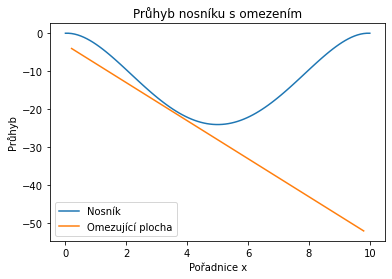

In [12]:
seminewton_solver(100, -1, ob_lin)

Converges in 35 iterations.


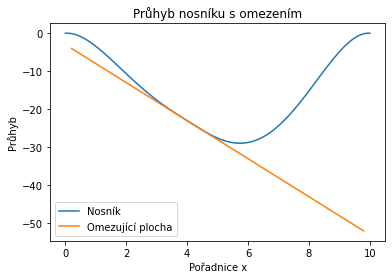

In [13]:
seminewton_solver(100, -3, ob_lin)

Converges in 32 iterations.


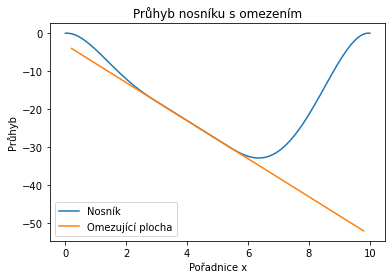

In [14]:
seminewton_solver(100, -7, ob_lin)

Converges in 32 iterations.


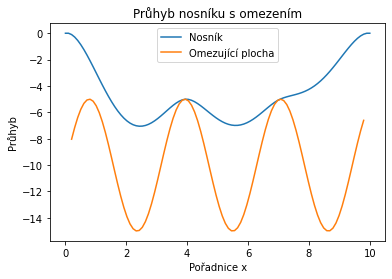

In [25]:
def ob_sin(xi):
    return 5*np.sin(2*xi)-10

seminewton_solver(100, -7, ob_sin)